# ACF and PACF
# Autocorrelation Function / Partial Autocorrelation Function
Before we can investigate <em>autoregression</em> as a modeling tool, we need to look at <em>covariance</em> and <em>correlation</em> as they relate to lagged (shifted) samples of a time series.


### Goals
 * Be able to create ACF and PACF charts
 * Create these charts for multiple times series, one with seasonality and another without
 * Be able to calculate Orders PQD terms for ARIMA off these charts (highlight where they cross the x axis)

<div class="alert alert-info"><h3>Related Functions:</h3>
<tt><strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.acovf.html'>stattools.acovf</a></strong><font color=black>(x[, unbiased, demean, fft, …])</font>&nbsp;Autocovariance for 1D<br>
<strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.acf.html'>stattools.acf</a></strong><font color=black>(x[, unbiased, nlags, qstat, …])</font>&nbsp;&nbsp;Autocorrelation function for 1d arrays<br>
<strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.pacf.html'>stattools.pacf</a></strong><font color=black>(x[, nlags, method, alpha])</font>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Partial autocorrelation estimated<br>
<strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.pacf_yw.html'>stattools.pacf_yw</a></strong><font color=black>(x[, nlags, method])</font>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Partial autocorrelation estimated with non-recursive yule_walker<br>
<strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.pacf_ols.html'>stattools.pacf_ols</a></strong><font color=black>(x[, nlags])</font>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Calculate partial autocorrelations</tt>

<h3>Related Plot Methods:</h3>
<tt><strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html'>tsaplots.plot_acf</a></strong><font color=black>(x)</font>&nbsp;&nbsp;&nbsp;Plot the autocorrelation function<br>
<strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html'>tsaplots.plot_pacf</a></strong><font color=black>(x)</font>&nbsp;&nbsp;Plot the partial autocorrelation function</tt>

<h3>For Further Reading:</h3>
<strong>
<a href='https://en.wikipedia.org/wiki/Autocovariance'>Wikipedia:</a></strong>&nbsp;&nbsp;<font color=black>Autocovariance</font><br>
<strong>
<a href='https://otexts.com/fpp2/autocorrelation.html'>Forecasting: Principles and Practice</a></strong>&nbsp;&nbsp;<font color=black>Autocorrelation</font><br>
<strong>
<a href='https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc4463.htm'>NIST Statistics Handbook</a></strong>&nbsp;&nbsp;<font color=black>Partial Autocorrelation Plot</font></div>

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import statsmodels.api as sm
from statsmodels.tsa.stattools import acovf,acf,pacf,pacf_yw,pacf_ols
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Load a non-stationary dataset
df1 = pd.read_csv('../Data/airline_passengers.csv',index_col='Month',parse_dates=True)
df1.index.freq = 'MS'

# Load a stationary dataset
df2 = pd.read_csv('../Data/DailyTotalFemaleBirths.csv',index_col='Date',parse_dates=True)
df2.index.freq = 'D'

In [4]:
df1

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


In [5]:
df2

,Births
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44
...,...
1959-12-27,37
1959-12-28,52
1959-12-29,48


## Autocovariance for 1D
In a <em>deterministic</em> process, like $y=sin(x)$, we always know the value of $y$ for a given value of $x$. However, in a <em>stochastic</em> process there is always some randomness that prevents us from knowing the value of $y$. Instead, we analyze the past (or <em>lagged</em>) behavior of the system to derive a probabilistic estimate for $\hat{y}$.

One useful descriptor is <em>covariance</em>. When talking about dependent and independent $x$ and $y$ variables, covariance describes how the variance in $x$ relates to the variance in $y$. Here the size of the covariance isn't really important, as $x$ and $y$ may have very different scales. However, if the covariance is positive it means that $x$ and $y$ are changing in the same direction, and may be related.

With a time series, $x$ is a fixed interval. Here we want to look at the variance of $y_t$ against lagged or shifted values of $y_{t+k}$

For a stationary time series, the autocovariance function for $\gamma$ (gamma) is given as:

${\displaystyle {\gamma}_{XX}(t_{1},t_{2})=\operatorname {Cov} \left[X_{t_{1}},X_{t_{2}}\right]=\operatorname {E} [(X_{t_{1}}-\mu _{t_{1}})(X_{t_{2}}-\mu _{t_{2}})]}$

We can calculate a specific $\gamma_k$ with:

${\displaystyle \gamma_k = \frac 1 n \sum\limits_{t=1}^{n-k} (y_t - \bar{y})(y_{t+k}-\bar{y})}$


### Autocovariance Example:
Say we have a time series with five observations: {13, 5, 11, 12, 9}.<br>
We can quickly see that $n = 5$, the mean $\bar{y} = 10$, and we'll see that the variance $\sigma^2 = 8$.<br>
The following calculations give us our covariance values:
<br><br>
$\gamma_0 = \frac {(13-10)(13-10)+(5-10)(5-10)+(11-10)(11-10)+(12-10)(12-10)+(9-10)(9-10)} 5 = \frac {40} 5 = 8.0 \\
\gamma_1 = \frac {(13-10)(5-10)+(5-10)(11-10)+(11-10)(12-10)+(12-10)(9-10)} 5 = \frac {-20} 5 = -4.0 \\
\gamma_2 = \frac {(13-10)(11-10)+(5-10)(12-10)+(11-10)(9-10)} 5 = \frac {-8} 5 = -1.6 \\
\gamma_3 = \frac {(13-10)(12-10)+(5-10)(9-10)} 5 = \frac {11} 5 = 2.2 \\
\gamma_4 = \frac {(13-10)(9-10)} 5 = \frac {-3} 5 = -0.6$
<br><br>
Note that $\gamma_0$ is just the population variance $\sigma^2$

Let's see if statsmodels gives us the same results! For this we'll create a <strong>fake</strong> dataset:

In [9]:
df = pd.DataFrame({'a':[13, 5, 11, 12, 9]})
arr = acovf(df['a'])
arr

array([ 8. , -4. , -1.6,  2.2, -0.6])

## Autocorrelation for 1D
The correlation $\rho$ (rho) between two variables $y_1,y_2$ is given as:

### $\rho = \frac {\operatorname E[(y_1−\mu_1)(y_2−\mu_2)]} {\sigma_{1}\sigma_{2}} = \frac {\operatorname {Cov} (y_1,y_2)} {\sigma_{1}\sigma_{2}}$,

where $E$ is the expectation operator, $\mu_{1},\sigma_{1}$ and $\mu_{2},\sigma_{2}$ are the means and standard deviations of $y_1$ and $y_2$.

When working with a single variable (i.e. <em>autocorrelation</em>) we would consider $y_1$ to be the original series and $y_2$ a lagged version of it. Note that with autocorrelation we work with $\bar y$, that is, the full population mean, and <em>not</em> the means of the reduced set of lagged factors (see note below).

Thus, the formula for $\rho_k$ for a time series at lag $k$ is:

${\displaystyle \rho_k = \frac {\sum\limits_{t=1}^{n-k} (y_t - \bar{y})(y_{t+k}-\bar{y})} {\sum\limits_{t=1}^{n} (y_t - \bar{y})^2}}$

This can be written in terms of the covariance constant $\gamma_k$ as:

${\displaystyle \rho_k = \frac {\gamma_k n} {\gamma_0 n} = \frac {\gamma_k} {\sigma^2}}$

For example,<br>
$\rho_4 = \frac {\gamma_4} {\sigma^2} = \frac{-0.6} {8} = -0.075$

Note that ACF values are bound by -1 and 1. That is, ${\displaystyle -1 \leq \rho_k \leq 1}$

In [7]:
df=pd.DataFrame({'a':[13,5,11,12,9]})
df

,a
0,13
1,5
2,11
3,12
4,9


In [8]:
'''
So now that I have this data frame, what I'm going to do is calculate the autocorrelation for it in
one dimension.

Remember, it's just the correlation between the lag that time series.
'''
acf(df)

array([ 1.   , -0.5  , -0.2  ,  0.275, -0.075])

## Partial Autocorrelation
Partial autocorrelations measure the linear dependence of one variable after removing the effect of other variable(s) that affect both variables. That is, the partial autocorrelation at lag $k$ is the autocorrelation between $y_t$ and $y_{t+k}$ that is not accounted for by lags $1$ through $k−1$.

A common method employs the non-recursive <a href='https://en.wikipedia.org/wiki/Autoregressive_model#Calculation_of_the_AR_parameters'>Yule-Walker Equations</a>:

$\phi_0 = 1\\
\phi_1 = \rho_1 = -0.50\\
\phi_2 = \frac {\rho_2 - {\rho_1}^2} {1-{\rho_1}^2} = \frac {(-0.20) - {(-0.50)}^2} {1-{(-0.50)}^2}= \frac {-0.45} {0.75} = -0.60$

As $k$ increases, we can solve for $\phi_k$ using matrix algebra and the <a href='https://en.wikipedia.org/wiki/Levinson_recursion'>Levinson–Durbin recursion</a> algorithm which maps the sample autocorrelations $\rho$ to a <a href='https://en.wikipedia.org/wiki/Toeplitz_matrix'>Toeplitz</a> diagonal-constant matrix. The full solution is beyond the scope of this course, but the setup is as follows:


$\displaystyle \begin{pmatrix}\rho_0&\rho_1&\cdots &\rho_{k-1}\\
\rho_1&\rho_0&\cdots &\rho_{k-2}\\
\vdots &\vdots &\ddots &\vdots \\
\rho_{k-1}&\rho_{k-2}&\cdots &\rho_0\\
\end{pmatrix}\quad \begin{pmatrix}\phi_{k1}\\\phi_{k2}\\\vdots\\\phi_{kk}\end{pmatrix}
\mathbf = \begin{pmatrix}\rho_1\\\rho_2\\\vdots\\\rho_k\end{pmatrix}$

In [10]:
'''
And then we have to actually pass in a specific number of Lag's we want to do this for.
so you can say nlags=4 and we'll go ahead and say 4 because we have 5 rows.
and value of nlags=n-1 so 5-1=4 so nlags=4.

then we'll also specify the method='mle'.
And so we passed Method mle above here in order to use the biased acf coefficients and MLE stands for
maximum likelihood estimation.

So when you run this, you'll get back an array of the partial autocorrelation function values.

'''

pacf_yw(df['a'],nlags=4,method='mle')

array([ 1.        , -0.5       , -0.6       , -0.38541667, -0.40563273])

### Partial Autocorrelation with OLS
This provides partial autocorrelations with <a href='https://en.wikipedia.org/wiki/Ordinary_least_squares'>ordinary least squares</a> (OLS) estimates for each lag instead of Yule-Walker.

In [11]:
'''
now stats models also provides another partial
autocorrelation function, pacf_ols and this provides partial autocorrelation of ordinary
least squares, estimates for each leg instead of the youw Walker equations.

basic premise behind why there's different ways of calculating partial autocorrelation
function is because there's actually different ways of calculating correlation itself.

In fact, you may be familiar with the term Peerson correlation coefficient, and that's because that's
a actually a particular equation for measuring correlation, the Peerson correlation coefficient.

So if you keep expanding on that idea that there's different ways of measuring error and measuring correlation,
then as you imagine, there'd be different ways of measuring partial autocorrelation function.

'''
pacf_ols(df['a'],nlags=4)

array([ 1.        , -0.49677419, -0.43181818,  0.53082621,  0.25434783])

# Plotting
The arrays returned by <tt>.acf(df)</tt> and <tt>.pacf_yw(df)</tt> show the magnitude of the autocorrelation for a given $y$ at time $t$. Before we look at plotting arrays, let's look at the data itself for evidence of autocorrelation.

Pandas has a built-in plotting function that plots increasing $y_t$ values on the horizontal axis against lagged versions of the values $y_{t+1}$ on the vertical axis. If a dataset is non-stationary with an upward trend, then neighboring values should trend in the same way. Let's look at the <strong>Airline Passengers</strong> dataset first.

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

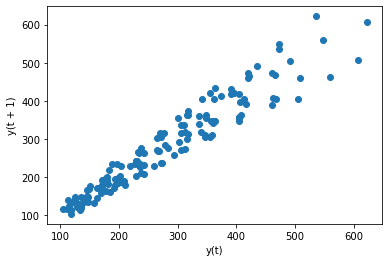

In [12]:
'''
So if we call like plot here, so if we take a look at this result, PANDAS has that built-In plotting

function that plots increasing Y(T) values on the horizontal axis against lagged versions of the values

Y(T+1) vertical axis.

If a data set is non stationary with an upward trend, then neighboring values should trend the same
way.

So here we can see the airline passengers.
And visually, this shows evidence of very strong autocorrelation.

So we can see here that clearly there's some sort of correlation between Y(T) and then Y(T+1)
, which is indicative of autocorrelation.
'''

from pandas.plotting import lag_plot

lag_plot(df1["Thousands of Passengers"])


Visually this shows evidence of a very strong autocorrelation; as $y_t$ values increase, nearby (lagged) values also increase.

Now let's look at the stationary <strong>Daily Total Female Births</strong> dataset:

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

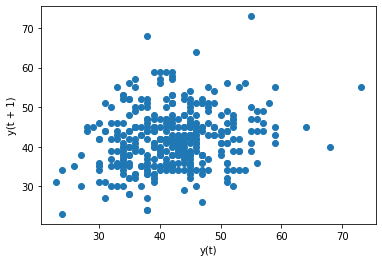

In [14]:
'''
Let's look now at the stationary data set.

And run that notice now we don't get something with nearly as much correlation between Y(T) and Y(T+1)


So then there's little evidence here indicating that there's strong auto correlation for many legs for
the births data set, which in part makes sense.
You wouldn't expect the number of births on one day to be highly correlated with the day before or the
day after.
'''

lag_plot(df2['Births'])

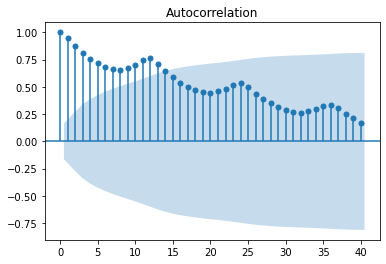

In [17]:
'''
And notice again, there's clear indication of seasonality in the data because there's these general
peaks and the autocorrelation.

So there's these little local maximums which indicates that at a certain point the auto correlation
starts to increase, which makes sense because they're happening around a yearly basis.


So what we may also be interested in is that we have this shaded region.

Well, by default, this is a 95 percent confidence interval.
And basically all that means is it's suggesting that correlation values outside of this confidence interval
are very highly likely to be a correlation.

And notice your shaded region gets larger and larger as your legs gets larger and larger as well, which
kind of makes sense.
You're going to be more sure of the smaller lags steps for autocorrelation than the larger lags steps.

'''

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

plot_acf(df1,lags=40);

This plot indicates non-stationary data, as there are a large number of lags before ACF values drop off.

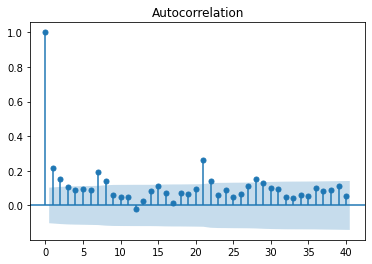

In [18]:
'''
So this is the autocorrelation plot for the stationary data.

There's a very sharp drop off because it's stationary.
You don't see this sort of behavior indicating anything of seasonality.

'''
plot_acf(df2,lags=40);

This is a typical ACF plot for stationary data, with lags on the horizontal axis and correlations on the vertical axis. The first value $y_0$ is always 1. A sharp dropoff indicates that there is no AR component in the ARIMA model.

Next we'll look at non-stationary data with the <strong>Airline Passengers</strong> dataset:

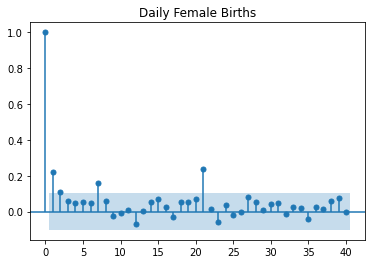

In [21]:
'''
So in general, partial autocorrelation plots work best with data that's already stationary.
'''

plot_pacf(df2,lags=40,title="Daily Female Births");

To make the <strong>Airline Passengers</strong> data stationary, we'll first apply <em>differencing</em>:

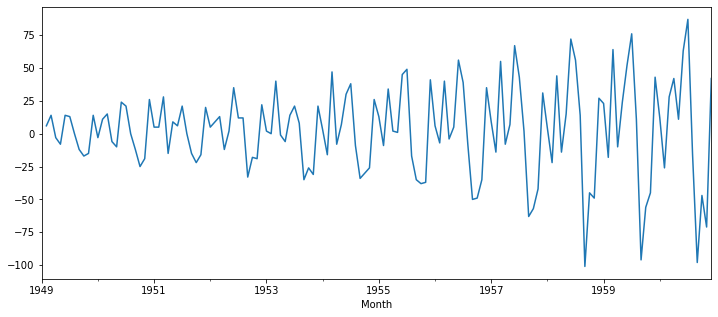

In [22]:
from statsmodels.tsa.statespace.tools import diff

df1['d1'] = diff(df1['Thousands of Passengers'],k_diff=1)
df1['d1'].plot(figsize=(12,5));

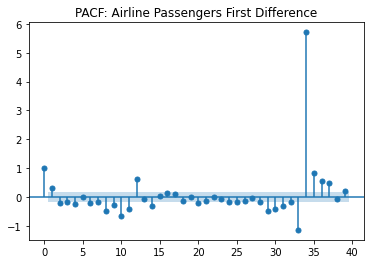

In [23]:
title='PACF: Airline Passengers First Difference'
lags=40
plot_pacf(df1['d1'].dropna(),title=title,lags=np.arange(lags));  # be sure to add .dropna() here!

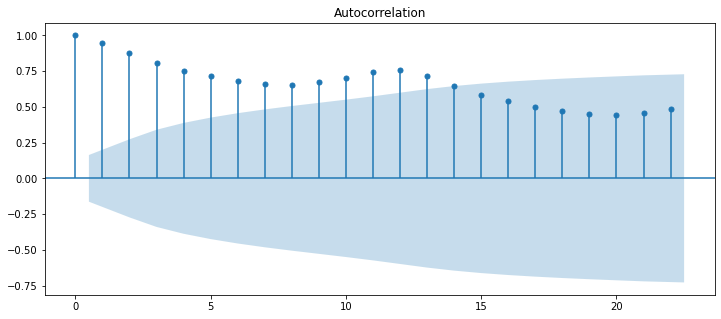

In [25]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,5))

plot_acf(df1['Thousands of Passengers'],ax=ax);

<div class="alert alert-success"><strong>A NOTE ABOUT AUTOCORRELATION:</strong> Some texts compute lagged correlations using the Pearson Correlation Coefficient given by:<br><br>
${\displaystyle r_{xy}={\frac {\sum _{i=1}^{n}(x_{i}-{\bar {x}})(y_{i}-{\bar {y}})}{{\sqrt {\sum _{i=1}^{n}(x_{i}-{\bar {x}})^{2}}}{\sqrt {\sum _{i=1}^{n}(y_{i}-{\bar {y}})^{2}}}}}}$

These are easily calculated in numpy with <tt>numpy.corrcoef(x,y)</tt> and in Excel with <tt>=CORREL(x,y)</tt>.<br><br>
Using our example, $r_0$ is still $1$, but to solve for $r_1$:

${\displaystyle x_1 = [13, 5, 11, 12], \bar{x_1} = 10.25}$<br><br>
$y_1 = [5, 11, 12, 9],\  \bar{y_1} = 9.25$<br><br>
$r_{{x_1}{y_1}}=\frac {(13-10.25)(5-9.25)+(5-10.25)(11-9.25)+(11-10.25)(12-9.25)+(12-10.25)(9-9.25)}
{\sqrt{((13-10.25)^2+(5-10.25)^2+(11-10.25)^2+(12-10.25)^2)}\sqrt{((5-9.25)^2+(11-9.25)^2+(12-9.25)^2+(9-9.25)^2)}} = \frac {-19.25} {33.38} = -0.577$
<br><br>
However, there are some shortcomings. Using the Pearson method, the second-to-last term $r_{k-1}$ will always be $1$ and the last term $r_k$ will always be undefined.
</div>